<a href="https://colab.research.google.com/github/desultir/assign1/blob/master/assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
  
#!cd "/content/drive/My Drive/Colab Notebooks/PretrainedModels" && tar xvzf *.tar.gz
#!cd "/content/drive/My Drive/Colab Notebooks/Input" && tar xvzf test.tar.gz

Mounted at /content/drive


In [0]:
#install tensorboard tunnel
#https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-17 05:32:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.201.75.180, 52.72.145.109, 3.214.163.243, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.201.75.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16529980 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.4’

ngrok-stable-linux- 100%[===================>]  15.76M  44.4MB/s    in 0.4s    

2019-05-17 05:32:18 (44.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.4’ saved [16529980/16529980]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
MODEL_DIR = "/content/drive/My Drive/Colab Notebooks/PretrainedModels/"
MODEL_NAME = "faster_rcnn_resnet50_coco_2018_01_28"

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://eb233447.ngrok.io


In [0]:
from matplotlib.image import imread
import PIL.Image
from PIL import ImageOps
import numpy as np
import io

def normalize_image(rgb):
  white_rgb = rgb - np.mean(rgb)
  white_rgb = white_rgb / np.max(np.abs(white_rgb))
  return white_rgb

def decompress_expand(jpg):
  #zero pad to 320x320
  encoded_jpg_io = io.BytesIO(jpg)
  image = PIL.Image.open(encoded_jpg_io)
  DESIRED_SIZE = 320
  widthpad = (DESIRED_SIZE - image.width)
  heightpad = (DESIRED_SIZE - image.height)
  padding = (widthpad//2, heightpad//2, widthpad - widthpad//2, heightpad-heightpad//2)
  padded = ImageOps.expand(image, padding)
  return padded


def load_and_preprocess(path):
  with tf.gfile.GFile(path, 'rb') as fp:
    jpg = fp.read()
  return decompress_expand(jpg)

def load_np(paths):
  return np.stack([imread(x) for x in paths])

In [11]:
import glob
import csv
import tensorflow as tf
import os
from tensorflow.core.framework import graph_pb2
from tensorflow.python.saved_model import loader
AUTOTUNE = tf.data.experimental.AUTOTUNE

#load train images
train_img_list = glob.glob(r"/content/drive/My Drive/Colab Notebooks/Input/train2014/*.jpg")
image_list = map(load_and_preprocess, train_img_list)
#train_img_list_ds = tf.data.Dataset.from_tensor_slices(image_list)
#load train labels
train_labels_filename = r"/content/drive/My Drive/Colab Notebooks/Input/train.txt"
with open(train_labels_filename) as f:
  reader = csv.reader(f, delimiter='\t')
  train_labels = {k:list(map(int, v.split(','))) for k, v in reader}

len(train_img_list)

31925

0

In [0]:
#load the trainable model from the checkpoint
sess = tf.Session()
class_weights = tf.get_variable("SecondStageBoxPredictor/ClassPredictor/weights", shape=(2048, 91), trainable=True)
class_bias = tf.get_variable("SecondStageBoxPredictor/ClassPredictor/biases", shape=(91), trainable=True)

saver = tf.train.import_meta_graph(os.path.join(MODEL_DIR,MODEL_NAME, 'model.ckpt.meta'))

sess.run(tf.global_variables_initializer())
saver.restore(sess, os.path.join(MODEL_DIR,MODEL_NAME, 'model.ckpt'))



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/PretrainedModels/faster_rcnn_resnet50_coco_2018_01_28/model.ckpt


In [0]:
# write graph for tensorboard
summary_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

In [0]:
BATCH_SIZE = 10
batch_no = 0
batch_list = []
result_list = []
while image_list:
  try:
    while len(batch_list) < BATCH_SIZE:
      batch_list.append(next(image_list))
  except StopIteration:
    pass
  stacked_imgs = np.stack(batch_list)
  batch_result = sess.run(("detection_classes:0", "detection_scores:0"), feed_dict={"image_tensor:0": stacked_imgs})
  batch_list = []
  batch_no += 1
  print(batch_no)
  result_list.append(batch_result)
  
  
#result = sess.run(("SecondStagePostprocessor/convert_scores:0", "detection_classes:0", "num_detections:0"), feed_dict={"image_tensor:0": stacked_imgs})

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


ValueError: ignored

In [0]:
from scipy import stats
#np.argmax(result[0][3][:,3]) # prediction
#result[1][3] #scores
#preds = np.argmax(result[0], axis=2)
#result[1][3]

array([0.9916928 , 0.9882533 , 0.9400895 , 0.88384396, 0.6351711 ,
       0.49882242, 0.39083028, 0.34901962, 0.32091033, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [0]:
import pickle
with open("/content/drive/My Drive/Colab Notebooks/full_results.pk", 'wb') as f:
  pickle.dump(result_list, f)

NameError: ignored

In [0]:
class relabeler(object):
  def __init__(self):
    self.labels = {}
     #mapping from cocolabel to tutorlabel + 1 (0 reserved for 'reject bounding box')
    self.labels[9] = 1 #boat 
    self.labels[10] = 5 #traffic light 
    self.labels[14] = 6 #parking meter
    self.labels[15] = 7 #bench
    self.labels[16] = 18 #bird
    self.labels[28] = 19 #umbrella
    self.labels[31] = 20 #handbag
    self.labels[36] = 2 #snowboard
    self.labels[39] = 4 #baseball bat
    self.labels[41] = 3 #skateboard
    self.labels[44] = 10 #bottle
    self.labels[49] = 9 #knife
    self.labels[50] = 8 #spoon
    self.labels[52] = 15 #banana
    self.labels[54] = 13 #sandwich
    self.labels[57] = 14 #carrot
    self.labels[79] = 17 #oven
    self.labels[80] = 16 #toaster
    self.labels[85] = 12 #clock
    self.labels[90] = 11 #toothbrush   
    self.fix_fn = self.get_fix_fn()
    
  def fix(self, old):
    return self.labels.get(old, 0)
  
  def get_fix_fn(self):
    return np.vectorize(self.fix)
    
  def get_best_label(self, preds):
    #convert to new label space and get best label
    labels = self.fix_fn(preds)
    #return labels
    #return first that isn't 0
    if len(np.nonzero(labels)[0]):
      return labels[np.nonzero(labels)[0][0]] - 1 #shift back into original label space
    else:
      return -1 #1 

In [2]:
import pickle
#unpickle resulst file
with open("/content/drive/My Drive/Colab Notebooks/full_results.pk", 'rb') as f:
  results_list = pickle.load(f)
  
len(results_list)

3193

In [3]:
import numpy as np
results = [x[0] for x in results_list]
stacked_results = np.vstack(results)
stacked_results.shape

(31925, 100)

In [0]:
#convert preds back into tutor space
fixer = relabeler()
preds  = stacked_results
labels = list(map(fixer.get_best_label, preds))


In [12]:
from collections import Counter
correct = 0
labelled = zip(train_img_list, labels)
confusion = Counter() # (pred, actual) : count

y_true = []
y_pred = []

for fn, pred in labelled:
  truth = train_labels[fn.split("/")[-1]]
  if pred in truth:
    correct += 1
    y_true.append(pred)
    y_pred.append(pred)
  else:
    for truelabel in truth: 
      confusion[(pred, truelabel)] += 1
      y_true.append(truelabel)
      y_pred.append(pred)
    #print(fn, pred, truth)
    
print(correct, len(train_img_list))
print(confusion)

20902 31925
Counter({(-1, 19): 1960, (-1, 6): 1265, (-1, 9): 1043, (-1, 8): 711, (-1, 3): 690, (-1, 11): 598, (-1, 7): 565, (-1, 2): 559, (-1, 16): 440, (-1, 18): 395, (-1, 17): 330, (-1, 1): 299, (-1, 4): 264, (-1, 12): 250, (-1, 0): 231, (-1, 14): 207, (-1, 10): 142, (9, 8): 124, (-1, 13): 124, (9, 16): 97, (-1, 5): 89, (9, 19): 87, (9, 7): 85, (9, 11): 66, (4, 19): 59, (6, 19): 55, (1, 2): 55, (18, 19): 52, (12, 8): 51, (8, 7): 45, (7, 8): 40, (6, 2): 40, (9, 12): 38, (-1, 15): 37, (12, 7): 36, (0, 6): 35, (9, 10): 27, (19, 9): 27, (0, 19): 27, (0, 18): 27, (6, 9): 26, (12, 9): 26, (18, 6): 26, (13, 8): 26, (8, 9): 26, (16, 9): 25, (4, 11): 24, (6, 18): 24, (0, 2): 23, (9, 6): 23, (4, 6): 22, (6, 11): 22, (13, 7): 22, (13, 12): 22, (13, 14): 22, (6, 0): 21, (17, 6): 21, (13, 9): 21, (2, 19): 20, (19, 6): 20, (12, 13): 18, (4, 18): 18, (19, 3): 18, (18, 2): 18, (8, 19): 18, (17, 0): 17, (16, 8): 17, (9, 14): 17, (2, 3): 16, (7, 9): 16, (17, 18): 16, (0, 1): 15, (11, 6): 14, (4, 2): 1

Confusion matrix, without normalization
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [ 231 1373    3    3    2    7    0   21    0    1    7    0    4    0
     2    0    0    0   17    7    4]
 [ 299   15  619   11    1   12    1    5    0    0    1    2    1    0
     0    0    0    0    6    8    3]
 [ 559   23   55 1621    3   14    0   40    0    2   10    2    4    0
     2    0    0    0    2   18    8]
 [ 690    3    0   16  770    2    1    4    0    2    6    4    3    0
     3    0    0    0    8    4   18]
 [ 264    5    0    2    0 1523    2    6    0    0    1    0    4    1
     0    0    0    0    3    4    5]
 [  89    2    0    0    0    6  278    3    0    0    1    0    1    0
     0    0    0    0    2    3    3]
 [1265   35    5    9    5   22    5 1429    1    4   23    2   14    4
     4    3    0    4   21   26   20]
 [ 565    1    0    1    2    6    2    6  374   45   85   14    5   36
    22  

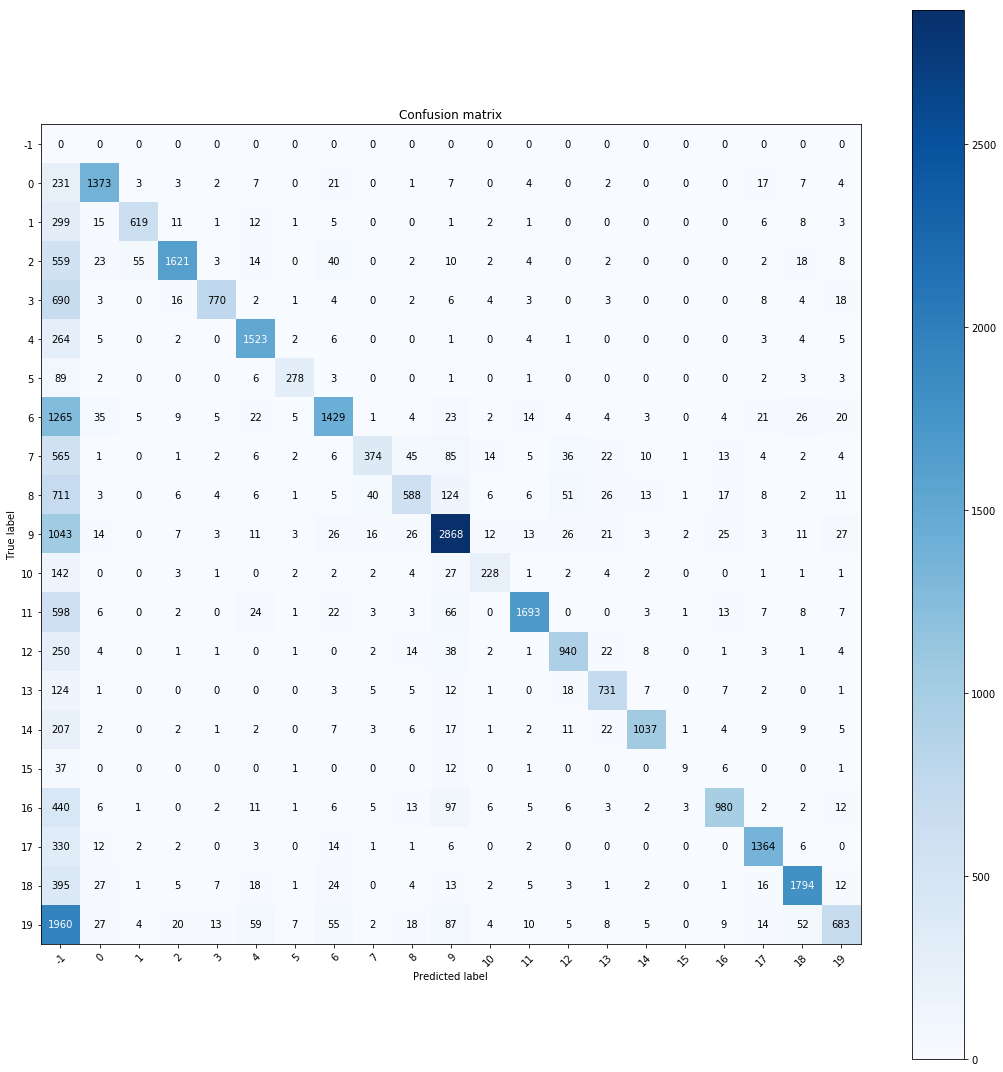

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#reference https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=[x for x in range(-1,20)],
                      title='Confusion matrix')


In [0]:
label_pl = tf.placeholder(tf.int32, [None, None, 1], name='labels')
#mapping from ben
fixfn = relabeler().get_fix_fn()
labels = fixfn(preds)
#TODO add mean here if batch training
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=sess.graph.get_tensor_by_name("SecondStagePostprocessor/convert_scores:0"), labels=label_pl)
cost = tf.reduce_mean(loss)
# Train op
#with tf.name_scope("train"):
# Get gradients of all trainable variables
# TODO actually pass vars in, not their names
var_list = [class_weights, class_bias]
#gradients = tf.gradients(loss, var_list, unconnected_gradients='none')
#gradients = list(zip(gradients, var_list))
learning_rate = 0.01

# Create optimizer and apply gradient descent to the trainable variables
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
#train_op = optimizer.apply_gradients(grads_and_vars=gradients)

ValueError: ignored

In [0]:
gradients

[(None,
  <tf.Variable 'SecondStageBoxPredictor/ClassPredictor/weights:0' shape=(2048, 91) dtype=float32_ref>),
 (None,
  <tf.Variable 'SecondStageBoxPredictor/ClassPredictor/biases:0' shape=(91,) dtype=float32_ref>)]

In [0]:
sess.graph.get_tensor_by_name("SecondStageBoxPredictor/ClassPredictor/weights:0")
sess.graph.get_operation_by_name("SecondStageBoxPredictor/ClassPredictor/weights")

<tf.Operation 'SecondStageBoxPredictor/ClassPredictor/weights' type=VariableV2>

In [0]:
sess.run("SecondStageBoxPredictor/ClassPredictor/weights")